In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = '../res/tristan_md_trajectory_N125_F500_L10.0.xyz'

with open(path) as f:
    
    natoms = int(f.readline()) # per configurations
    nconfig = 1

    comment = f.readline().split()
    box_size = np.array(comment[9:12]).astype(float)
    frame = [comment[1]]
    time = [float(comment[4])]

    elements = []
    atompos = []
    configpos = []

    for line in f:

        split = line.split()
        nsplit = len(split)
        if nsplit > 4:

            frame.append(split[1])
            time.append(float(split[4]))
            atompos.append(configpos)
            configpos = []
            nconfig += 1

        elif nsplit == 4:

            if nconfig == 1:

                elements.append(split[0])

            configpos.append(split[1:4])

    atompos.append(configpos)
    atompos = np.array(atompos).astype(float)
    frame = np.array(frame)
    time = np.array(time)

In [3]:
from numba import njit, prange

@njit(parallel=True)
def msd(tau:float):

    assert 0 <= tau <= time[-1], f'Time interval must be between 0 and {time[-1]}'

    m = int(np.floor(tau / (time[1]-time[0])))
    s = 0

    for i in prange(natoms):

        for k in range(time.size - m):

            s += np.sum((atompos[k+m, i] - atompos[k, i])**2)

    return s/(time.size - m)/natoms

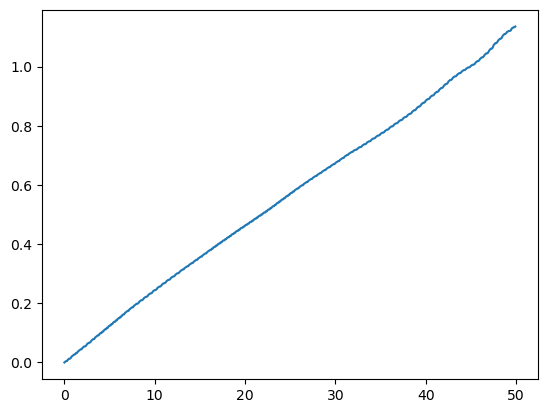

In [4]:
fig, ax = plt.subplots()
y = np.array([msd(t) for t in time])
ax.plot(time, y)

In [15]:
r_cut = box_size.max()*0.5
rsq_cut = r_cut**2

nbins = 200
r_bins = np.linspace(0, r_cut, nbins+1)

lattice = np.diag(box_size)
lattice_inv = np.diag(1/box_size)

density = natoms / np.prod(box_size)
volume_bins = 4 * np.pi * r_bins[1:]**2 * r_bins[1]

@njit(parallel=True)
def rdf():

    counts = np.zeros(nbins)

    for config in prange(nconfig):

        for i, pos_i in enumerate(atompos[config]):

            for j, pos_j in enumerate(atompos[config, (i+1):]):

                if j==i:
                    continue

                pos_ij = pos_j - pos_i
                pos_ij = pos_ij - lattice @ np.round(lattice_inv @ pos_ij) # image with the smallest norm

                rsq_ij = np.dot(pos_ij, pos_ij)

                if rsq_ij < rsq_cut:

                    counts[int(np.floor(np.sqrt(rsq_ij)/r_bins[1]))] += 2

    distribution = counts / (density * volume_bins * nconfig * natoms)

    return distribution

In [17]:
c = rdf()

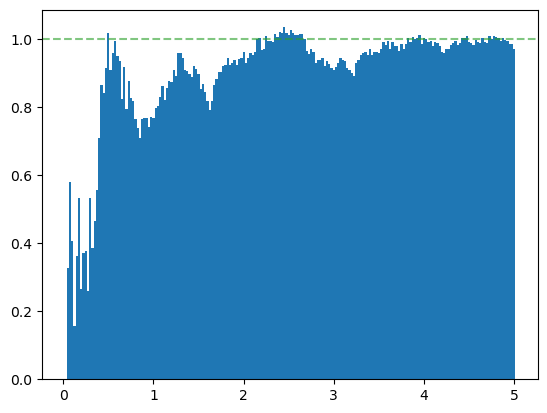

In [18]:
plt.bar(r_bins[1:], c, width=r_bins[1])
plt.axhline(y=1, linestyle = '--', color='tab:green', alpha=.6)
plt.show()